## Setup

In [1]:
#RUNNING ON ENVIRONMENT 'UNEXT'
# Config
seed = 42  # for reproducibility
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 5

# If the following values are False, the models will be downloaded and not computed
compute_histograms = False
train_whole_images = False 
train_patches = False

from IPython.display import display
import enum
import time
import random
import multiprocessing
from pathlib import Path

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt

from IPython.display import display
from tqdm.auto import tqdm

random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

/home/orolo/miniconda3/envs/unet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Print Debugging on!

UNET V3
Last run on Sat Aug 13 11:02:23 2022
TorchIO version: 0.18.76


In [3]:
tens = subject.sample[tio.DATA]
print(type(tens))
print(tens[0][0][0][0])
arr = np.array(tens)
print(np.max(arr) - np.min(arr))
modded_subjects[4]['sample'].data.shape

NameError: name 'subject' is not defined

In [2]:
import os
dataset_dir = Path(os.getcwd() + "/ALL_DATA/gzorg/")
images_dir = dataset_dir / 'images'
labels_dir = dataset_dir / 'labels'
image_paths = sorted(images_dir.glob('*.nii.gz'))
label_paths = sorted(labels_dir.glob('*.nii.gz'))
print(len(label_paths))
print(len(image_paths))

assert len(image_paths) == len(label_paths)


import time
modded_subjects = []

for (image_path, label_path) in tqdm((zip(image_paths, label_paths))):
    subject = tio.Subject(
        sample=tio.ScalarImage(image_path),
        label =  tio.LabelMap(label_path)
    )
    # print(subject['label1'].tensor[:,:,:,0].shape)

    modded_subjects.append(subject)
    time.sleep(0.5)

dataset = tio.SubjectsDataset(modded_subjects)

140
140


140it [01:10,  2.00it/s]


In [3]:
mul = 4
shapey = (48, mul*60, mul*48)

training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad(shapey),
    tio.RandomMotion(p=0.2),
    tio.RandomBiasField(p=0.3),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
    tio.OneHot(),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad(shapey),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(),
])


dataset = tio.SubjectsDataset(modded_subjects)

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
print(num_split_subjects)
training_subjects, validation_subjects = torch.utils.data.random_split(modded_subjects, num_split_subjects)

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

training_set_raw = [] 
val_set_raw = []

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

(126, 14)
Training set: 126 subjects
Validation set: 14 subjects


In [8]:
import pytorch_lightning
import os
import time

In [33]:
class CATDataModule(pytorch_lightning.LightningDataModule):
    def __init__(self):
        super().__init__()
        image_mul = 4
        self.image_shape = (48, image_mul*60, image_mul*48)
        self.training_subjects = []
        self.validation_subjects = []
        self.train_batch_size = 1
        self.val_batch_size = 1
        self.dataset = []

    def prepare_data(self, train_batch_size, val_batch_size):
        dataset_dir = Path(os.getcwd() + "/ALL_DATA/gzorg/")
        images_dir = dataset_dir / 'images'
        labels_dir = dataset_dir / 'labels'
        image_paths = sorted(images_dir.glob('*.nii.gz'))
        label_paths = sorted(labels_dir.glob('*.nii.gz'))
        assert len(image_paths) == len(label_paths)
        self.dataset = []
        for (image_path, label_path) in tqdm(zip(image_paths, label_paths), total=len(image_paths)):
            subject = tio.Subject(
                sample=tio.ScalarImage(image_path),
                label =  tio.LabelMap(label_path))
            self.dataset.append(subject)
            time.sleep(0.1)

    def setup(self):
        num_training_subjects = int(training_split_ratio * len(self.dataset))
        num_validation_subjects = len(self.dataset) - num_training_subjects

        num_split_subjects = num_training_subjects, num_validation_subjects
        self.training_subjects, self.validation_subjects = torch.utils.data.random_split(modded_subjects, num_split_subjects)
    
    def train_dataloader(self):
        training_transform = tio.Compose([
                    tio.ToCanonical(),
                    tio.Resample(4),
                    tio.CropOrPad(self.image_shape),
                    tio.RandomMotion(p=0.2),
                    tio.RandomBiasField(p=0.3),
                    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
                    tio.RandomNoise(p=0.5),
                    tio.RandomFlip(),
                    tio.OneOf({
                        tio.RandomAffine(): 0.8,
                        tio.RandomElasticDeformation(): 0.2,
                    }),
                    tio.OneHot()])

        validation_transform = tio.Compose([
                    tio.ToCanonical(),
                    tio.Resample(4),
                    tio.CropOrPad(self.image_shape),
                    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
                    tio.OneHot(),
                ])
        training_set = tio.SubjectsDataset(
                            training_subjects, transform=training_transform)

        training_loader = torch.utils.data.DataLoader(
                            training_set,
                            batch_size=self.train_batch_size,
                            shuffle=True,
                            num_workers=1)
        return training_loader

    def val_dataloader(self):
        validation_transform = tio.Compose([
                    tio.ToCanonical(),
                    tio.Resample(4),
                    tio.CropOrPad(shapey),
                    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
                    tio.OneHot(),
                ])
        validation_set = tio.SubjectsDataset(
                        validation_subjects, transform=validation_transform)
      
        validation_loader = torch.utils.data.DataLoader(
                        validation_set,
                        batch_size=self.val_batch_size,
                        num_workers=1)
        return validation_loader

                



In [34]:
module = CATDataModule()
module.prepare_data(4,4)
module.setup()
mod = module.val_dataloader()

100%|██████████| 140/140 [00:14<00:00,  9.92it/s]


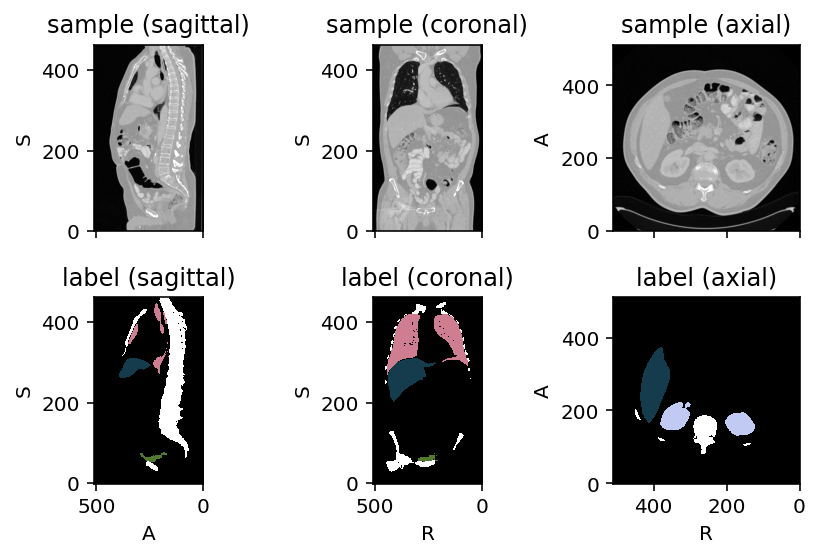

In [37]:
module.training_subjects[1].plot()

In [9]:
tens = training_subjects[0].sample.data


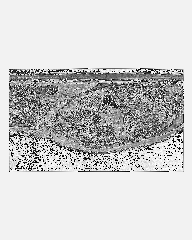

In [30]:
import random
ind = random.randint(0,tens.size()[1])
slice = tens[:, ind,:,:]
import torchvision.transforms.functional as F
img = F.to_pil_image(slice,mode='L')

display(img)


In [ ]:
edited_tens = 

In [ ]:
#plot 1 tensor, verify color space redux works

In [ ]:
dic = {}
dic['sample'] = it['sample'].data

In [ ]:
#@title (Deep learning functions, double-click here to expand)
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(batch, device):
    if device != None:
        inputs = batch['sample'][tio.DATA].to(device)
        targets = batch['label'][tio.DATA].to(device)
    else:
        inputs = batch['sample'][tio.DATA]
        targets = batch['label'][tio.DATA]

    print(f"DTYPE: {type(inputs)}")
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=6,
        dimensions=3,
        num_encoding_blocks=wandb.config['num_encoding_blocks'],
        out_channels_first_layer=wandb.config['out_channels_first_layer'],
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation=wandb.config['activation'],
    ).to(device)
    # print(model.parameters)
    optimizer = torch.optim.AdamW(model.parameters(), lr=wandb.config['learning_rate'])
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs)
            print(f"dtype: {inputs[0][0][0]}")
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets.short())
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean()}')
    return times, epoch_losses

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    train_losses = []
    val_losses = []
   

    # val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
    for epoch_idx in range(1, num_epochs + 1):


        print('Starting epoch', epoch_idx)
        train_loss = run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer)
        train_losses.append(train_loss)
        val_loss = run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer)
        val_losses.append(val_loss)

        wandb.log({"val_loss": val_loss})
        wandb.log({"train_loss": train_loss})

        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')
    return np.array(train_losses), np.array(val_losses)

In [ ]:
import wandb
wandb.init(project="3dUnet")
wandb.config = {
    #Model Parameters
  "num_encoding_blocks":3,
  "out_channels_first_layer":8,
  "activation": "PReLU",
    #Training Parameters
  "learning_rate": 0.001,
  "epochs": 10,
  "train_batch_size": 4,
  "val_batch_size":4
  
}

In [ ]:
if (torch.cuda.is_available()):
    print("Cuda is available")
model, optimizer = get_model_and_optimizer(device)
# wandb.watch(model)
weights_path = 'whole_image_state_dict.pth'
training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=wandb.config['train_batch_size'],
    shuffle=True,
    num_workers=1,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=wandb.config['val_batch_size'],
    num_workers=1,
)



In [ ]:
weights_stem = 'whole_images'
train_losses, val_losses = train(wandb.config['epochs'], training_loader, validation_loader, model, optimizer, weights_stem)
checkpoint = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'weights': model.state_dict(),
}
torch.save(checkpoint, weights_path)


#### Test

In [ ]:
checkpoint = torch.load(os.getcwd() + "/whole_images_epoch_1.pth", map_location=device)
model.load_state_dict(checkpoint['weights'])

In [ ]:
batch = next(iter(validation_loader))

In [ ]:
convert = tv.Compose([tv.ToPILImage()])

In [ ]:
# batch = next(iter(validation_loader))
batch = next(iter(test_loader))

model.eval()
inputs, targets = prepare_batch(batch, device)
with torch.no_grad():
    probabilities = model(inputs)

# affine = batch['sample'][tio.AFFINE][0].numpy()
# subject = tio.Subject(
#     mri=tio.ScalarImage(tensor=batch['sample'][tio.DATA][FIRST], affine=affine),
#     label=tio.LabelMap(tensor=batch['label'][tio.DATA][FIRST], affine=affine),
#     predicted=tio.ScalarImage(tensor=probabilities[FIRST], affine=affine),
# )


In [ ]:
probabilities.shape

In [ ]:
import torchvision.transforms.functional as F
img = F.to_pil_image(probabilities[:,5,24,:,:])

display(img)

In [ ]:
def stats(image):
    print(f"This image is {image.size[0]} by {image.size[1]}")
    arr = np.array(image)
    print(f"Mean pixel value is {np.mean(arr)}")
    print(f"Median pixel value is {np.median(arr)}")
    print(f"Minimum is {np.min(arr)}, Max is {np.max(arr)}")

In [ ]:
#WHY NO WORK?
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

In [ ]:
import torchvision.transforms as tv
convert = tv.Compose([tv.ToPILImage()])
slices = []
for i in range(6):
    slices.append(probabilities[:,i,24,:,:])

# im = convert(slices[1])
# imshow(im)
# stats(im)
affine = batch['sample'][tio.AFFINE][0].numpy()
ind = 24

pl1 = inputs.cpu()
pl2 = targets.cpu()
probs = probabilities.cpu()
subject = tio.Subject(
    scan=tio.ScalarImage(tensor=pl[:,:,ind,:,:]),
    label1=tio.LabelMap(tensor=pl2[:,:,ind,:,:],),
    predicted=tio.ScalarImage(tensor=probs[:,:,ind,:,:]),
)
subject.plot(figsize=(9, 8))#, cmap_dict={'predicted': 'RdBu_r'})

In [ ]:
# batch = next(iter(validation_loader))
batch = next(iter(training_loader))

model.eval()
inputs, targets = prepare_batch(batch, device)
FIRST = 0
FOREGROUND = 1
with torch.no_grad():
    probabilities = model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()
affine = batch['sample'][tio.AFFINE][0].numpy()
subject = tio.Subject(
    mri=tio.ScalarImage(tensor=batch['sample'][tio.DATA][FIRST], affine=affine),
    label=tio.LabelMap(tensor=batch['label'][tio.DATA][FIRST], affine=affine),
    predicted=tio.ScalarImage(tensor=probabilities[FIRST], affine=affine),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})